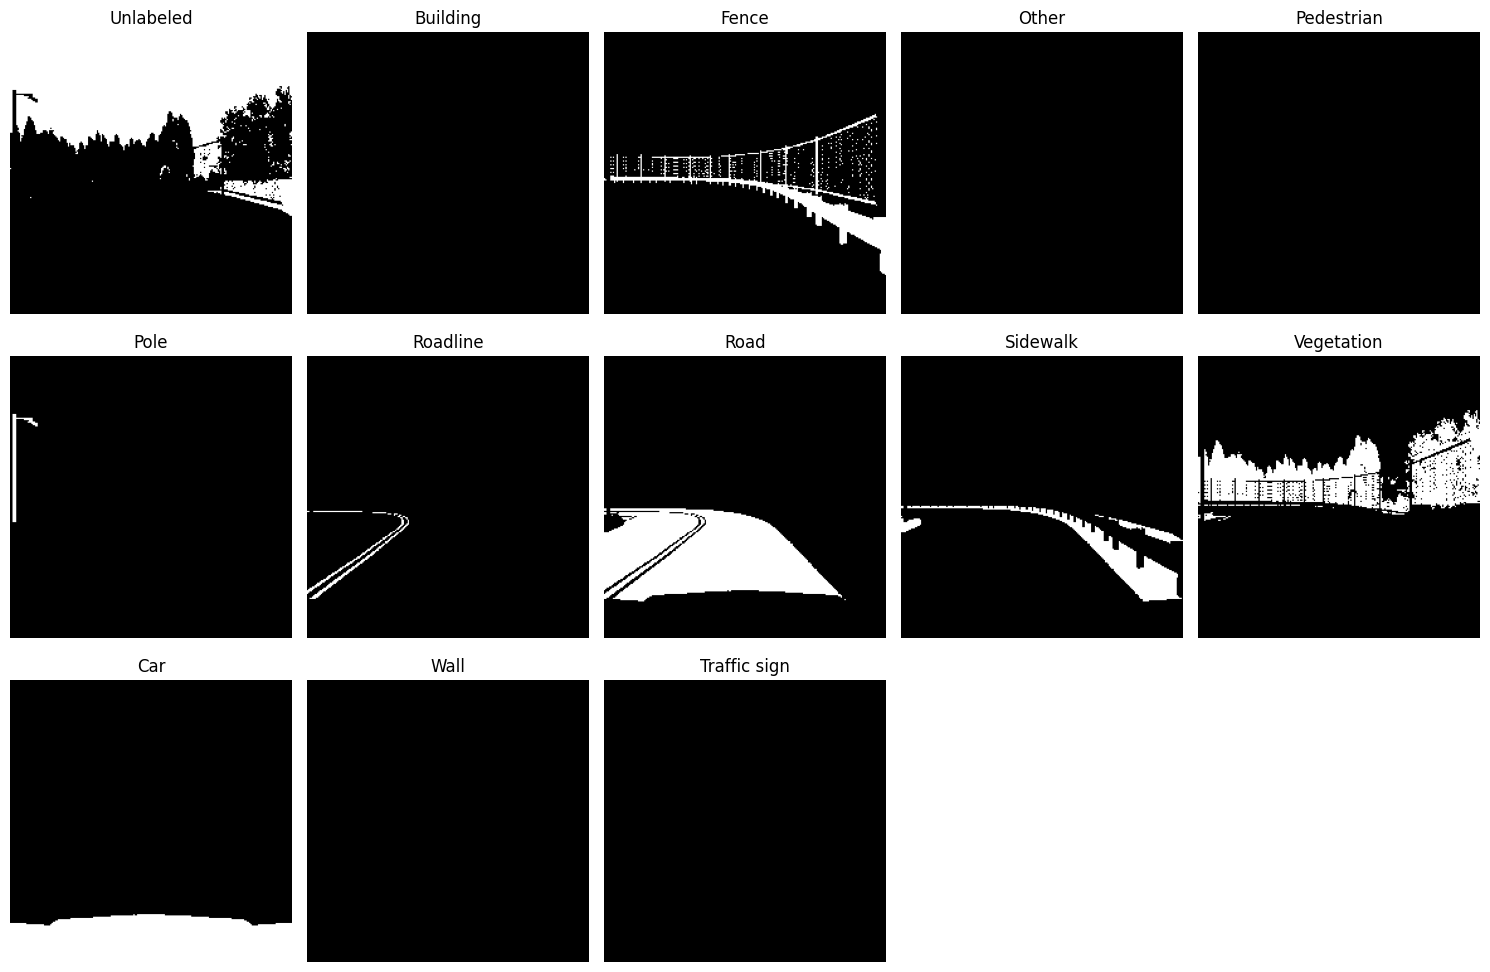

In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def visualize_segmentation_masks(dataset_path, num_classes=13):
    # Reads segmentation mask images, extracts the first channel,
    # isolates each of the 13 classes individually by creating binary masks,
    # and visualizes each binary mask with appropriate titles.
    labels_dir = os.path.join(dataset_path, 'dataset_224', 'train', 'labels')
    if not os.path.exists(labels_dir):
        raise ValueError(f"Labels directory not found: {labels_dir}")

    mask_files = [f for f in os.listdir(labels_dir) if f.endswith('.png')]
    if not mask_files:
        raise ValueError(f"No mask files found in: {labels_dir}")

    # Use the first mask file as a sample
    sample_mask_path = os.path.join(labels_dir, mask_files[0])
    mask = Image.open(sample_mask_path)
    mask = np.array(mask)
    
    # Extract the first channel
    mask = mask[:, :, 0]

    class_names = {
        0: "Unlabeled",
        1: "Building",
        2: "Fence",
        3: "Other",
        4: "Pedestrian",
        5: "Pole",
        6: "Roadline",
        7: "Road",
        8: "Sidewalk",
        9: "Vegetation",
        10: "Car",
        11: "Wall",
        12: "Traffic sign"
    }

    plt.figure(figsize=(15, 10))
    for class_id in range(num_classes):
        plt.subplot(3, 5, class_id + 1)  # 3 rows, 5 columns
        binary_mask = (mask == class_id).astype(np.uint8)
        plt.imshow(binary_mask, cmap='gray')
        plt.title(class_names.get(class_id, f"Class {class_id}"))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    dataset_path = '/kaggle/input/cvassignment-4'  # Replace with the actual path to your dataset
    try:
        visualize_segmentation_masks(dataset_path)
    except ValueError as e:
        print(f"Error: {e}")

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

# Explanation of FCN Variants:
#
# FCN-32s: This version upsamples the final feature map by a factor of 32
#           directly to the input image size. It's the simplest but least
#           precise variant.
#
# FCN-16s: This version combines the final feature map (upsampled by 2) with
#           the feature map from a previous layer (e.g., pool4 in VGG) and
#           then upsamples the combined feature map by 16. This incorporates
#           finer details from earlier layers.
#
# FCN-8s:  This version further combines the upsampled feature map from
#           FCN-16s with the feature map from an even earlier layer (e.g.,
#           pool3 in VGG) and then upsamples the result by 8. This captures
#           the finest details.
#
# The skip connections (adding feature maps from earlier layers) help to
# recover spatial information lost during downsampling in the encoder.


def get_backbone(pretrained=True, backbone_name='vgg16'):
    if backbone_name == 'vgg16':
        backbone = models.vgg16(pretrained=pretrained).features
        # Freeze backbone weights
        for param in backbone.parameters():
            param.requires_grad = False
        return backbone, 30, 23, 16  # Indices of pool5, pool4, pool3
    elif backbone_name == 'vgg19':
        backbone = models.vgg19(pretrained=pretrained).features
        for param in backbone.parameters():
            param.requires_grad = False
        return backbone, 36, 27, 18  # Indices of pool5, pool4, pool3
    else:
        raise ValueError("Unsupported backbone. Choose 'vgg16' or 'vgg19'.")


class FCN32s(nn.Module):
    def __init__(self, num_classes, backbone_name='vgg16'):
        super(FCN32s, self).__init__()
        self.backbone, pool5_idx, _, _ = get_backbone(backbone_name=backbone_name)
        self.pool5 = self.backbone[:pool5_idx+1]  # to pool5
        self.fcn = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, padding=3), # padding=3 to keep the size the same as after 7x7 conv with 1 padding in original paper
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, num_classes, kernel_size=1),
        )
        self.upsample = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16) # padding=16 to upsample by 32 with kernel 64

    def forward(self, x):
        x_size = x.size()
        x = self.pool5(x)
        x = self.fcn(x)
        x = self.upsample(x)
        return x


class FCN16s(nn.Module):
    def __init__(self, num_classes, backbone_name='vgg16'):
        super(FCN16s, self).__init__()
        self.backbone, pool5_idx, pool4_idx, _ = get_backbone(backbone_name=backbone_name)
        self.pool5 = self.backbone[:pool5_idx+1]
        self.pool4 = self.backbone[pool5_idx+1:pool4_idx+1]
        self.fcn = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, num_classes, kernel_size=1),
        )
        self.upsample2x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upsample16x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8) # padding=8 for kernel 32 and stride 16

    def forward(self, x):
        x_size = x.size()  # This is just storing the dimensions
        
        # Use x (the actual tensor) with the backbone
        pool4_features = self.backbone[:24](x)
        pool4 = self.pool4(pool4_features)
        
        # Continue with the rest of the model
        x = self.pool5(x)
        x = self.fcn(x)
        x = self.upsample2x(x)
        
        pool4 = self.score_pool4(pool4)
        x = x + pool4
        x = self.upsample16x(x)
        return x


class FCN8s(nn.Module):
    def __init__(self, num_classes, backbone_name='vgg16'):
        super(FCN8s, self).__init__()
        self.backbone, pool5_idx, pool4_idx, pool3_idx = get_backbone(backbone_name=backbone_name)
        self.pool5 = self.backbone[:pool5_idx+1]
        self.pool4 = self.backbone[pool5_idx+1:pool4_idx+1]
        self.pool3 = self.backbone[pool4_idx+1:pool3_idx+1]

        self.fcn = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, num_classes, kernel_size=1),
        )
        self.upsample2x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upsample2x_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.upsample8x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4) # padding=4 for kernel 16, stride 8

    def forward(self, x):
        x_size = x.size()
        
        # Use x (the actual tensor) with the backbone for different feature maps
        pool3_features = self.backbone[:17](x)
        pool3 = self.pool3(pool3_features)
        
        pool4_features = self.backbone[:24](x)
        pool4 = self.pool4(pool4_features)
        
        x = self.pool5(x)
        x = self.fcn(x)
        x = self.upsample2x(x)
        
        pool4 = self.score_pool4(pool4)
        x = x + pool4
        x = self.upsample2x_pool4(x)
        
        pool3 = self.score_pool3(pool3)
        x = x + pool3
        x = self.upsample8x(x)
        return x

Training FCN32s_vgg16_Frozen...
Epoch 1/10, Train Loss: 0.5233, Train mIoU: 0.6137, Val Loss: 0.3503, Val mIoU: 0.6951
Epoch 2/10, Train Loss: 0.3424, Train mIoU: 0.6931, Val Loss: 0.3055, Val mIoU: 0.7065
Epoch 3/10, Train Loss: 0.3023, Train mIoU: 0.7144, Val Loss: 0.2794, Val mIoU: 0.7228
Epoch 4/10, Train Loss: 0.2809, Train mIoU: 0.7268, Val Loss: 0.2694, Val mIoU: 0.7328
Epoch 5/10, Train Loss: 0.2691, Train mIoU: 0.7354, Val Loss: 0.2607, Val mIoU: 0.7406
Epoch 6/10, Train Loss: 0.2598, Train mIoU: 0.7403, Val Loss: 0.2485, Val mIoU: 0.7464
Epoch 7/10, Train Loss: 0.2516, Train mIoU: 0.7451, Val Loss: 0.2453, Val mIoU: 0.7454
Epoch 8/10, Train Loss: 0.2440, Train mIoU: 0.7495, Val Loss: 0.2404, Val mIoU: 0.7545
Epoch 9/10, Train Loss: 0.2392, Train mIoU: 0.7530, Val Loss: 0.2387, Val mIoU: 0.7501
Epoch 10/10, Train Loss: 0.2348, Train mIoU: 0.7550, Val Loss: 0.2340, Val mIoU: 0.7545


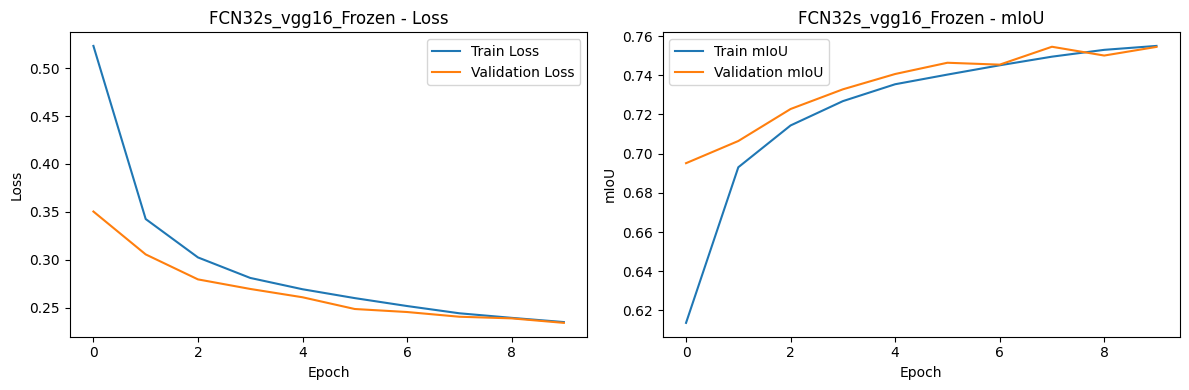

Evaluating FCN32s_vgg16_Frozen...
Test mIoU: 0.7569


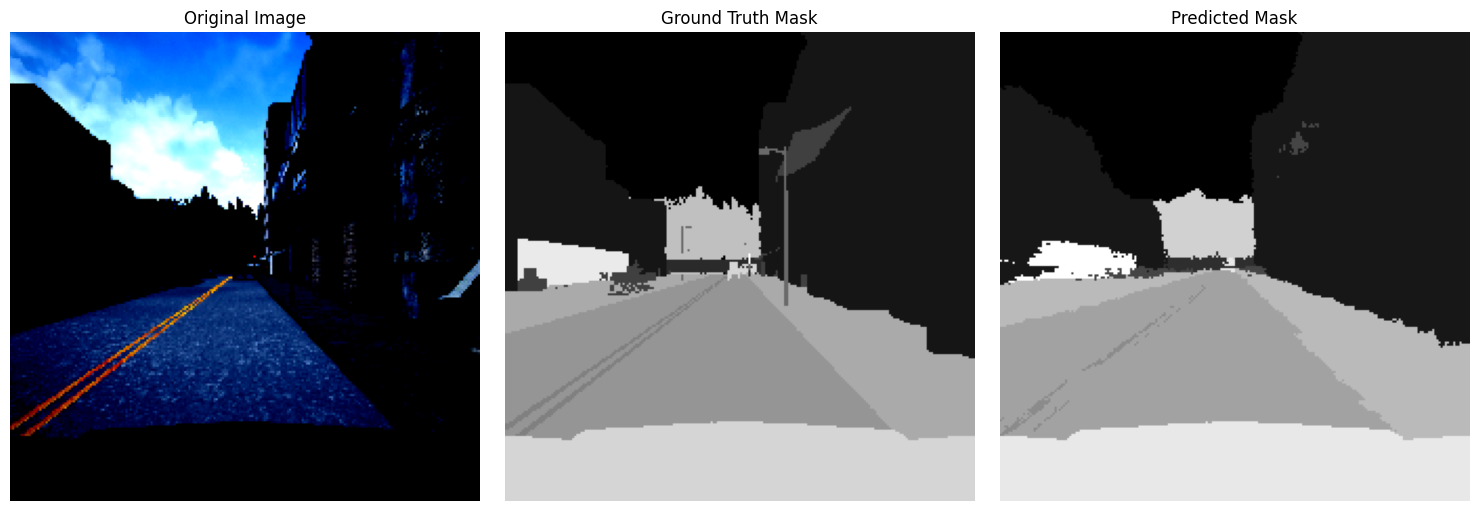

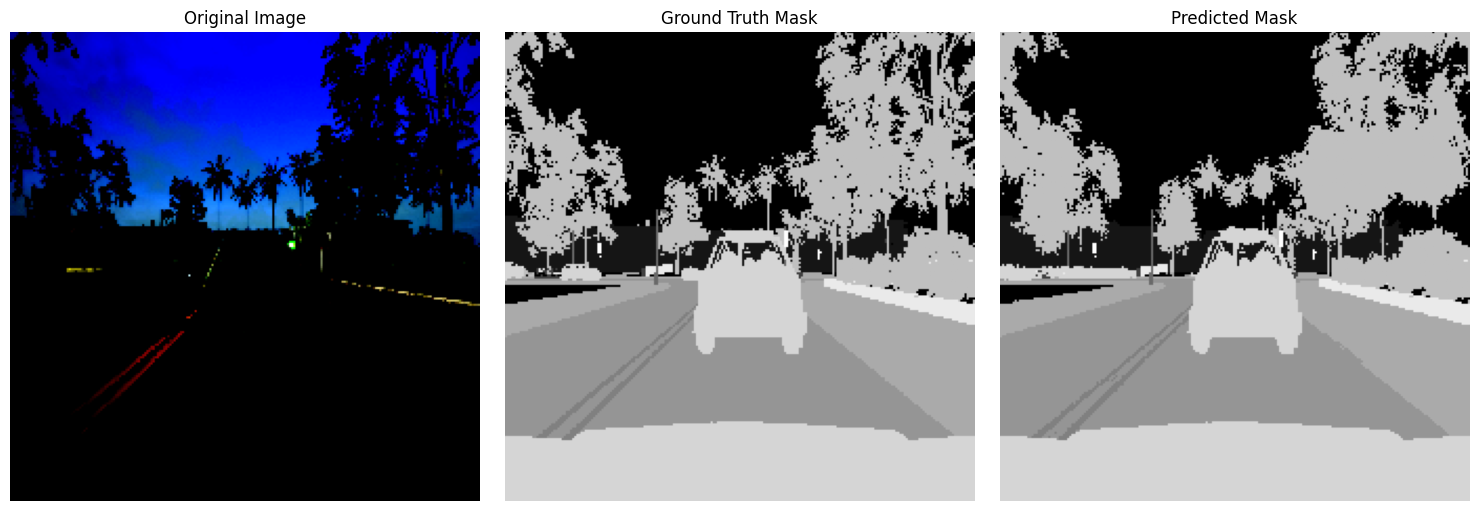

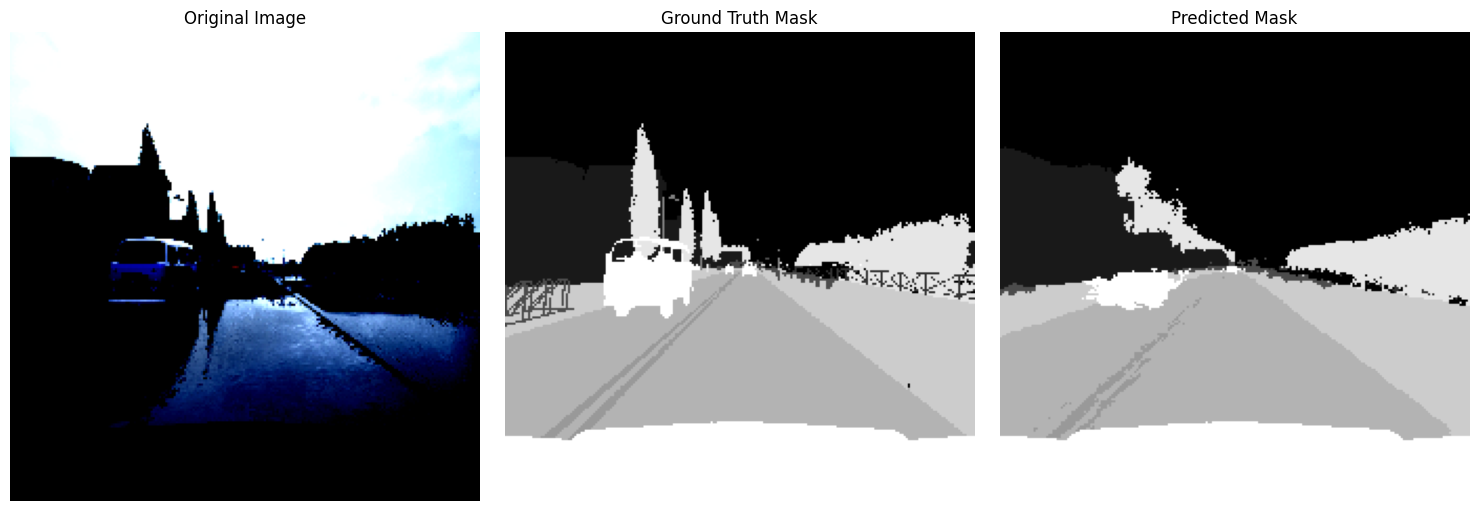

Training FCN16s_vgg16_Frozen...
Epoch 4/10, Train Loss: 0.2233, Train mIoU: 0.7678, Val Loss: 0.2223, Val mIoU: 0.7668
Epoch 5/10, Train Loss: 0.2128, Train mIoU: 0.7735, Val Loss: 0.2204, Val mIoU: 0.7660
Epoch 6/10, Train Loss: 0.2078, Train mIoU: 0.7758, Val Loss: 0.2122, Val mIoU: 0.7757
Epoch 7/10, Train Loss: 0.2014, Train mIoU: 0.7795, Val Loss: 0.2072, Val mIoU: 0.7780
Epoch 8/10, Train Loss: 0.1976, Train mIoU: 0.7819, Val Loss: 0.2050, Val mIoU: 0.7772
Epoch 9/10, Train Loss: 0.1939, Train mIoU: 0.7835, Val Loss: 0.2025, Val mIoU: 0.7801
Epoch 10/10, Train Loss: 0.1913, Train mIoU: 0.7855, Val Loss: 0.2013, Val mIoU: 0.7782


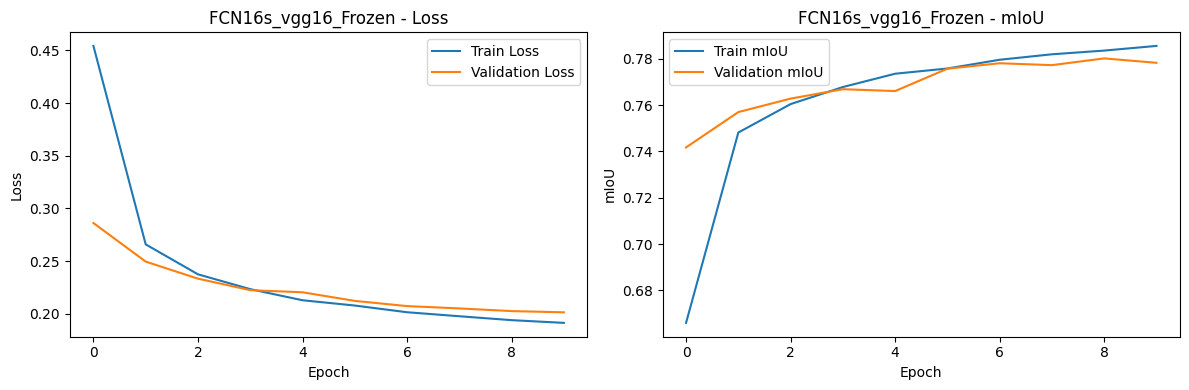

Evaluating FCN16s_vgg16_Frozen...
Test mIoU: 0.7815


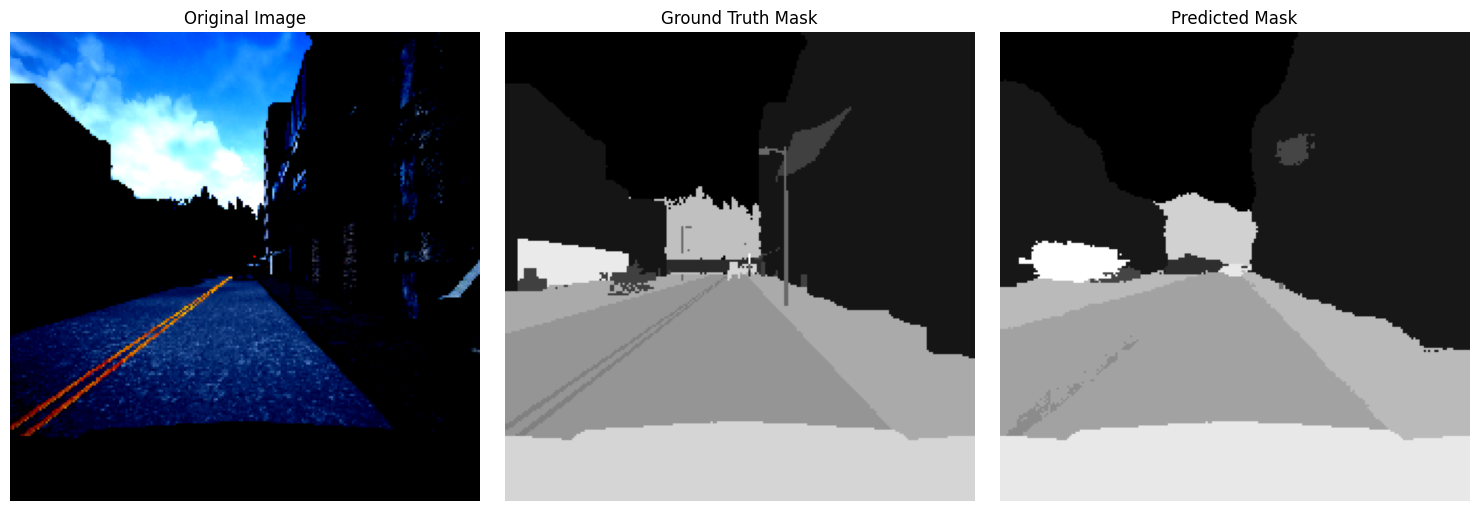

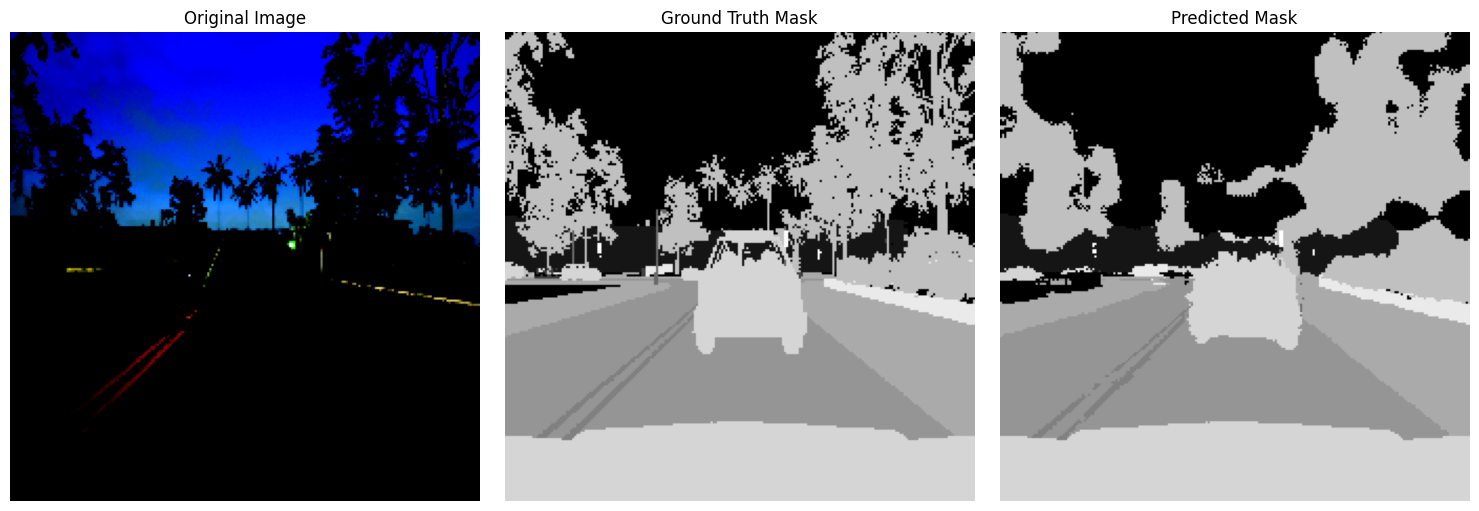

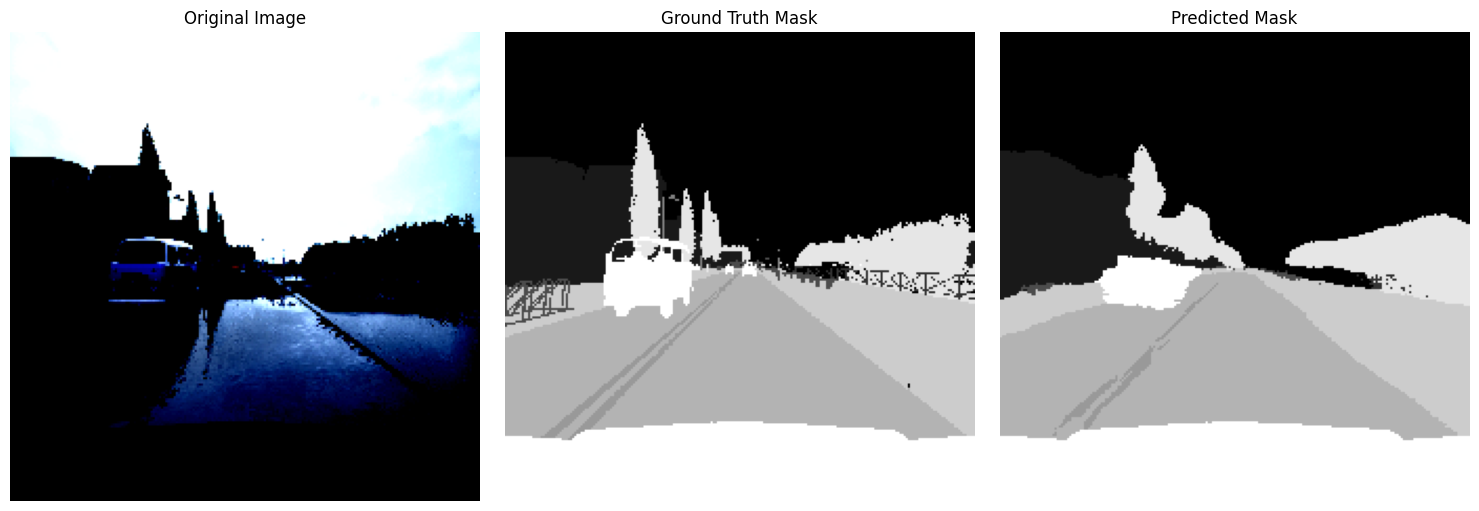

Training FCN8s_vgg16_Frozen...
Epoch 1/10, Train Loss: 0.4799, Train mIoU: 0.6871, Val Loss: 0.2614, Val mIoU: 0.7671
Epoch 2/10, Train Loss: 0.2416, Train mIoU: 0.7766, Val Loss: 0.2224, Val mIoU: 0.7847
Epoch 3/10, Train Loss: 0.2125, Train mIoU: 0.7894, Val Loss: 0.2039, Val mIoU: 0.7929
Epoch 4/10, Train Loss: 0.1974, Train mIoU: 0.7962, Val Loss: 0.1938, Val mIoU: 0.8006
Epoch 5/10, Train Loss: 0.1877, Train mIoU: 0.8010, Val Loss: 0.1903, Val mIoU: 0.8037
Epoch 6/10, Train Loss: 0.1824, Train mIoU: 0.8032, Val Loss: 0.1819, Val mIoU: 0.8009
Epoch 7/10, Train Loss: 0.1774, Train mIoU: 0.8056, Val Loss: 0.1803, Val mIoU: 0.8023
Epoch 8/10, Train Loss: 0.1726, Train mIoU: 0.8082, Val Loss: 0.1768, Val mIoU: 0.8046
Epoch 9/10, Train Loss: 0.1693, Train mIoU: 0.8093, Val Loss: 0.1741, Val mIoU: 0.8052
Epoch 10/10, Train Loss: 0.1673, Train mIoU: 0.8104, Val Loss: 0.1723, Val mIoU: 0.8068


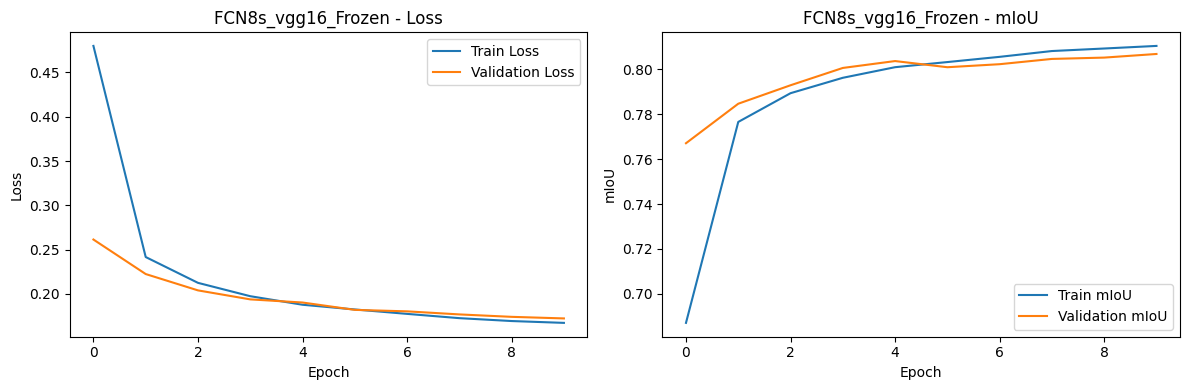

Evaluating FCN8s_vgg16_Frozen...
Test mIoU: 0.8098


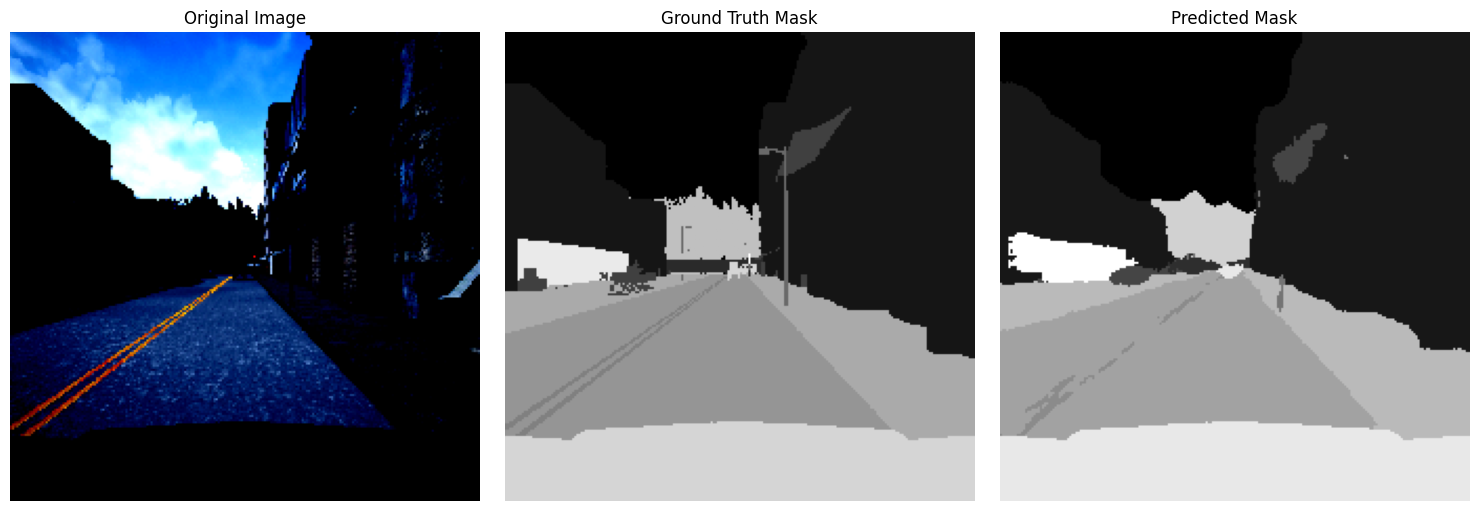

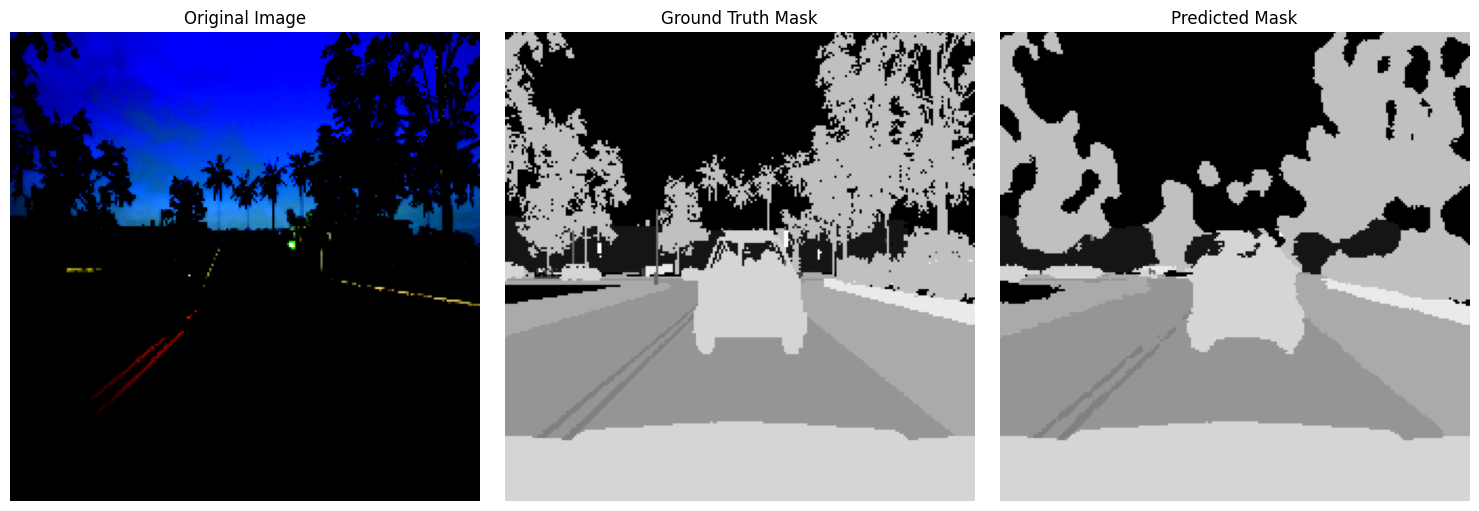

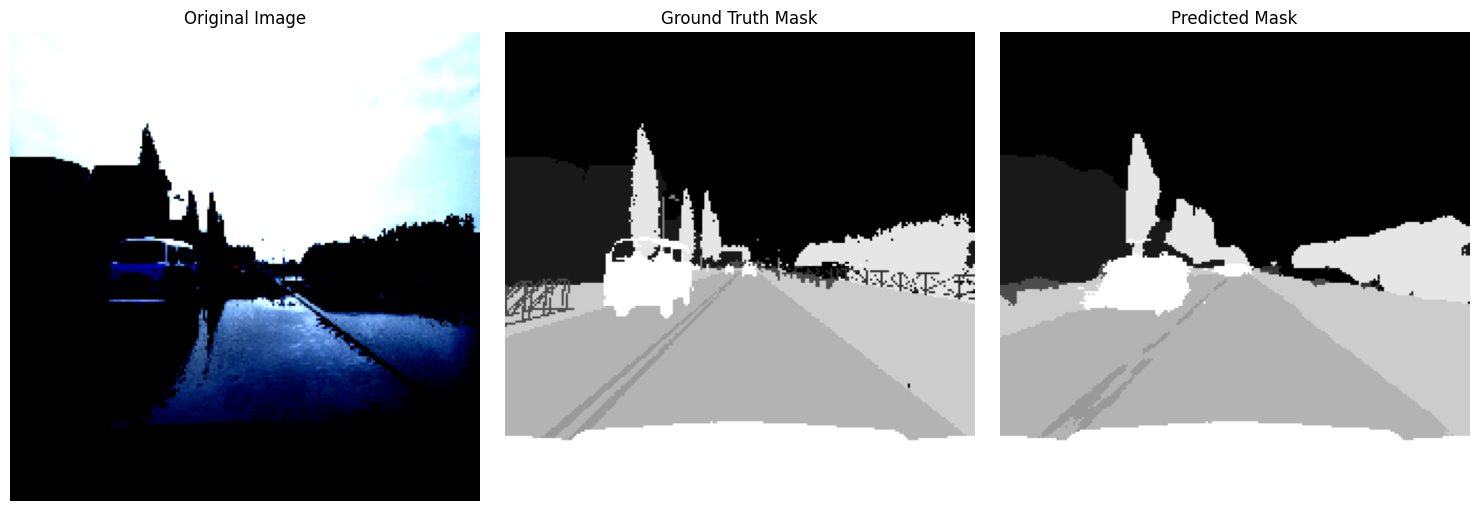

Training FCN32s_vgg16_FineTune...
Epoch 1/10, Train Loss: 0.9233, Train mIoU: 0.4696, Val Loss: 0.5414, Val mIoU: 0.6179
Epoch 2/10, Train Loss: 0.5023, Train mIoU: 0.6360, Val Loss: 0.4197, Val mIoU: 0.6721
Epoch 3/10, Train Loss: 0.4253, Train mIoU: 0.6739, Val Loss: 0.3693, Val mIoU: 0.6968
Epoch 4/10, Train Loss: 0.3780, Train mIoU: 0.6930, Val Loss: 0.3387, Val mIoU: 0.7142
Epoch 5/10, Train Loss: 0.3457, Train mIoU: 0.7083, Val Loss: 0.3190, Val mIoU: 0.7153
Epoch 6/10, Train Loss: 0.3227, Train mIoU: 0.7179, Val Loss: 0.2936, Val mIoU: 0.7290
Epoch 7/10, Train Loss: 0.3055, Train mIoU: 0.7241, Val Loss: 0.2871, Val mIoU: 0.7269
Epoch 8/10, Train Loss: 0.2949, Train mIoU: 0.7292, Val Loss: 0.2755, Val mIoU: 0.7406
Epoch 9/10, Train Loss: 0.2842, Train mIoU: 0.7344, Val Loss: 0.2679, Val mIoU: 0.7383
Epoch 10/10, Train Loss: 0.2746, Train mIoU: 0.7391, Val Loss: 0.2598, Val mIoU: 0.7421


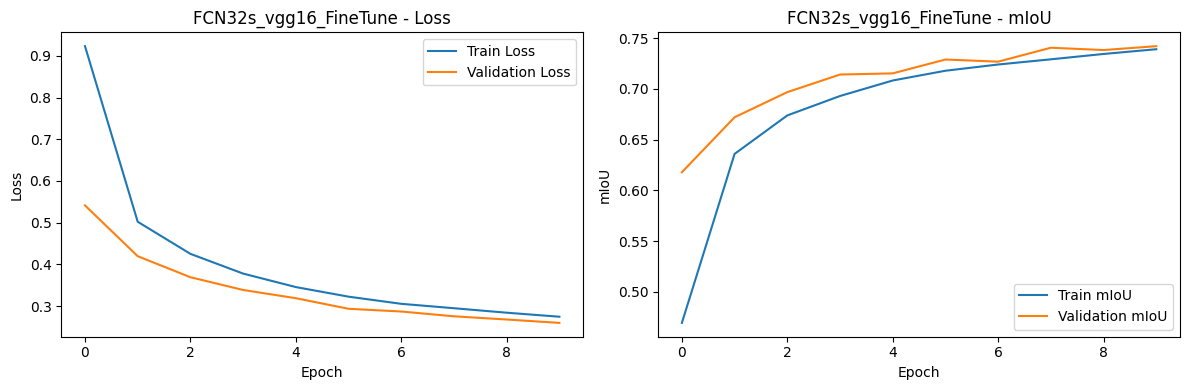

Evaluating FCN32s_vgg16_FineTune...
Test mIoU: 0.7455


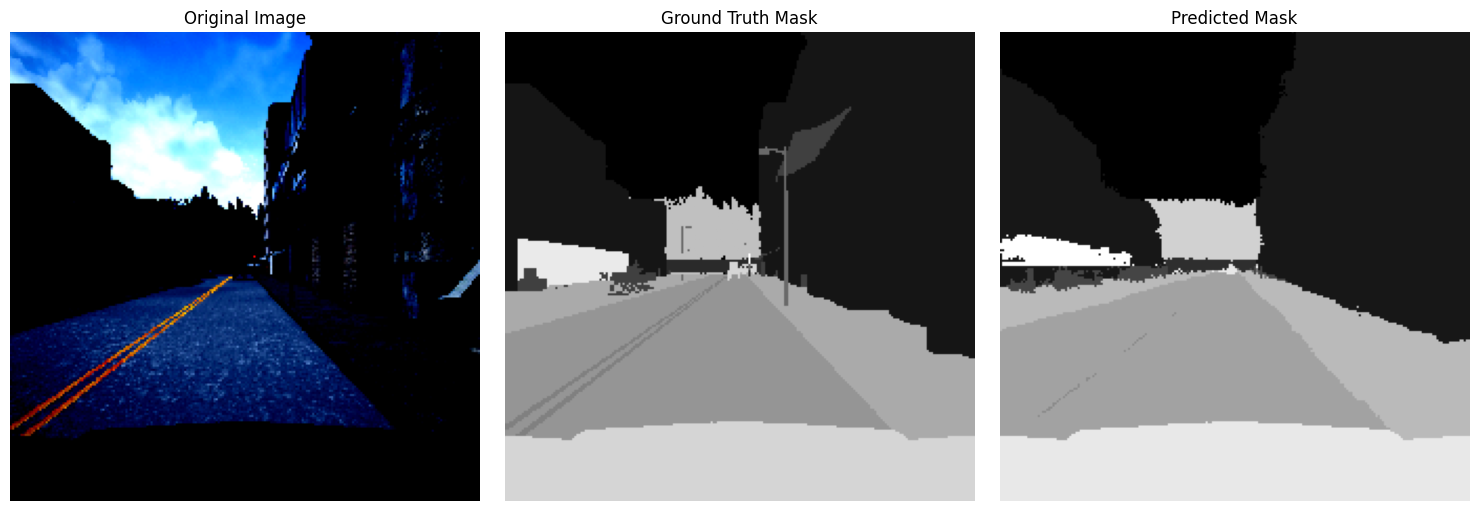

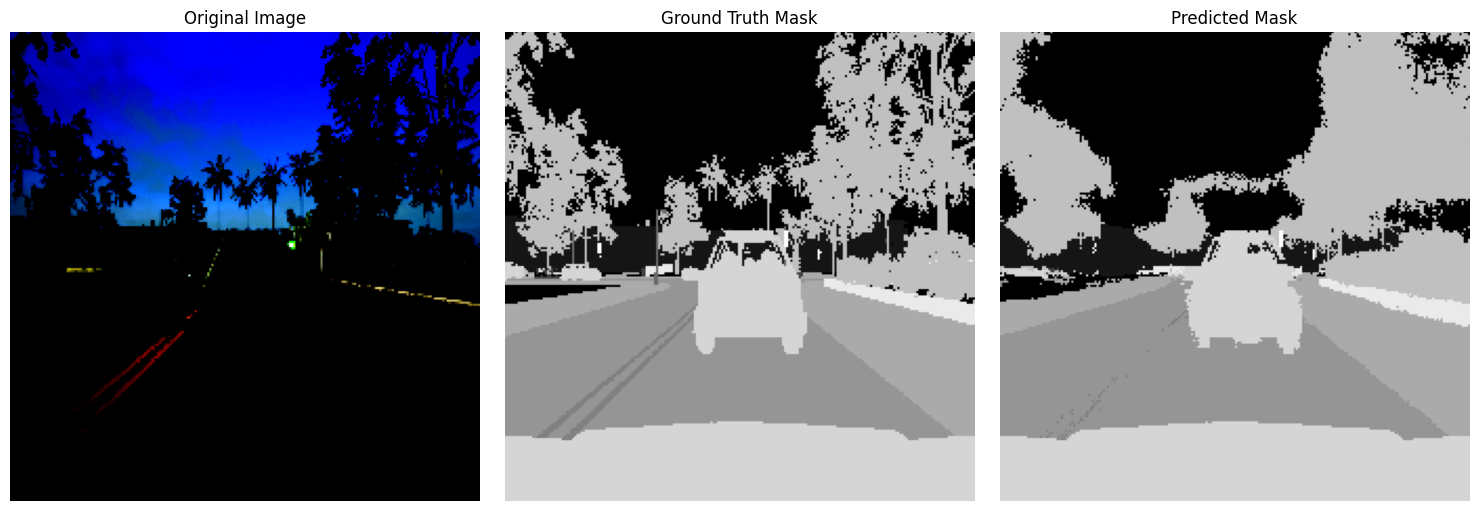

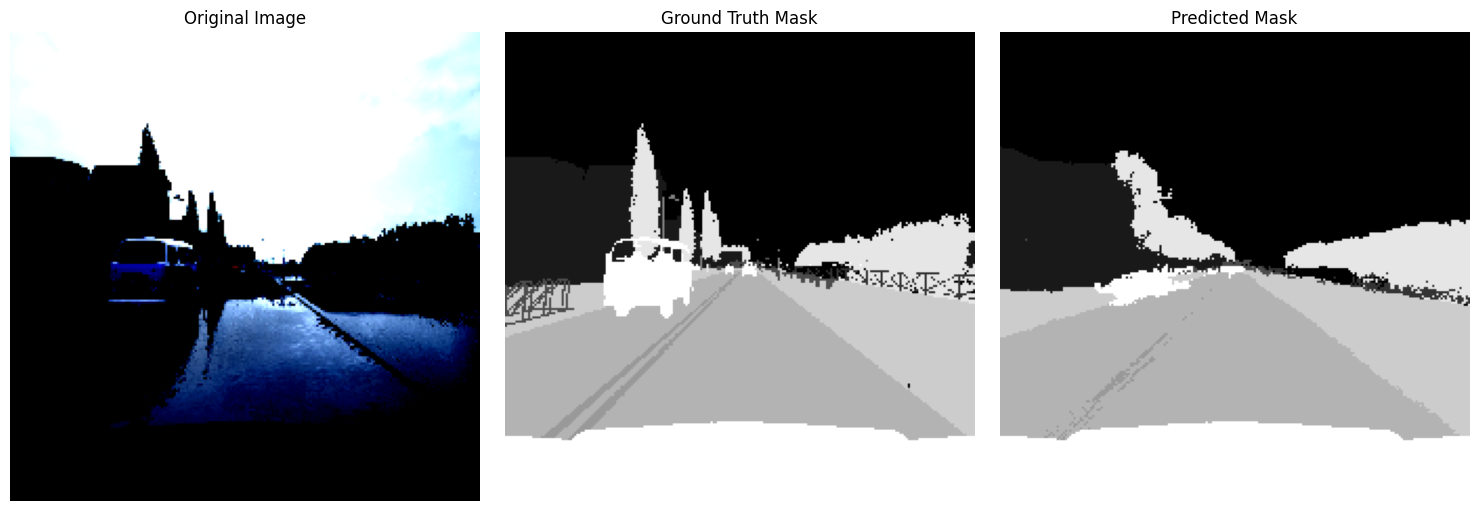

Training FCN16s_vgg16_FineTune...
Epoch 1/10, Train Loss: 0.5863, Train mIoU: 0.6401, Val Loss: 0.3048, Val mIoU: 0.7463
Epoch 2/10, Train Loss: 0.2547, Train mIoU: 0.7689, Val Loss: 0.2325, Val mIoU: 0.7800
Epoch 3/10, Train Loss: 0.2030, Train mIoU: 0.7899, Val Loss: 0.1982, Val mIoU: 0.7917
Epoch 4/10, Train Loss: 0.1757, Train mIoU: 0.8015, Val Loss: 0.1705, Val mIoU: 0.8043
Epoch 5/10, Train Loss: 0.1570, Train mIoU: 0.8110, Val Loss: 0.1629, Val mIoU: 0.8038
Epoch 6/10, Train Loss: 0.1460, Train mIoU: 0.8169, Val Loss: 0.1549, Val mIoU: 0.8107
Epoch 7/10, Train Loss: 0.1383, Train mIoU: 0.8216, Val Loss: 0.1456, Val mIoU: 0.8154
Epoch 8/10, Train Loss: 0.1311, Train mIoU: 0.8258, Val Loss: 0.1416, Val mIoU: 0.8208
Epoch 9/10, Train Loss: 0.1267, Train mIoU: 0.8284, Val Loss: 0.1390, Val mIoU: 0.8215
Epoch 10/10, Train Loss: 0.1228, Train mIoU: 0.8314, Val Loss: 0.1363, Val mIoU: 0.8244


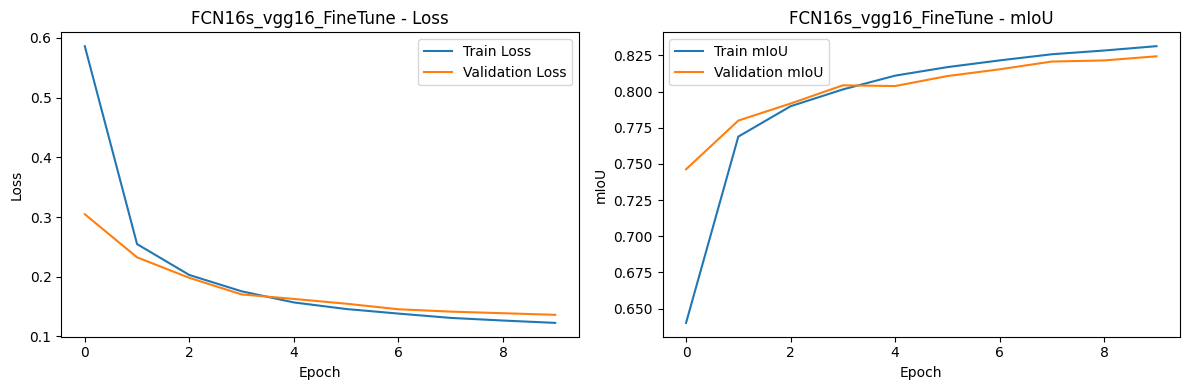

Evaluating FCN16s_vgg16_FineTune...
Test mIoU: 0.8282


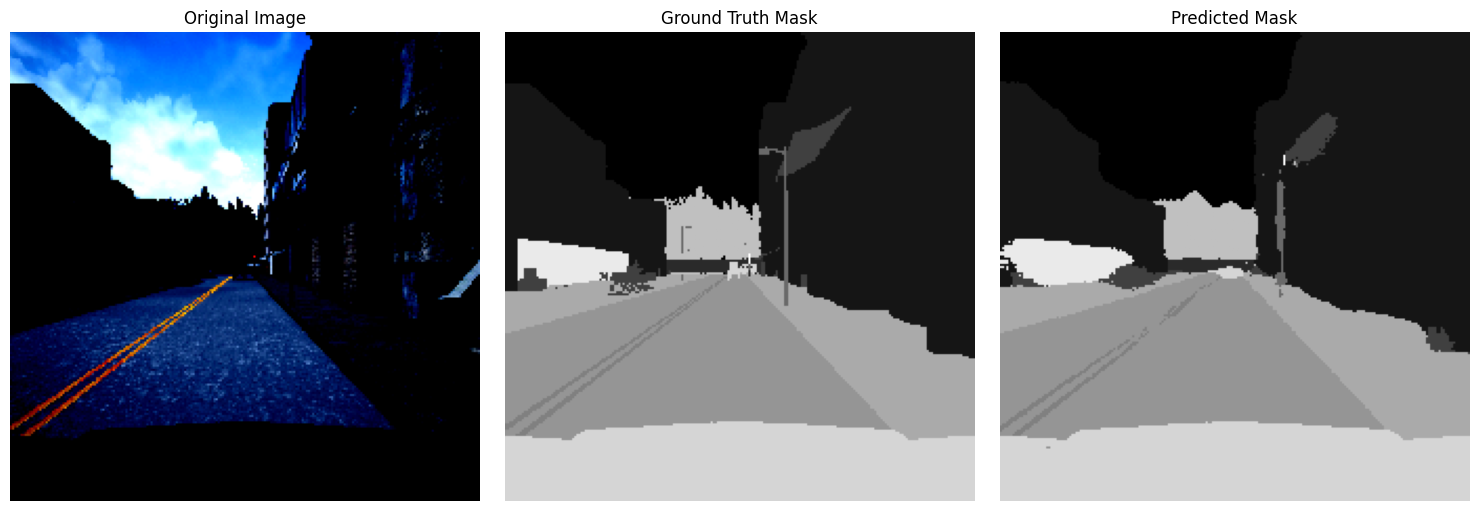

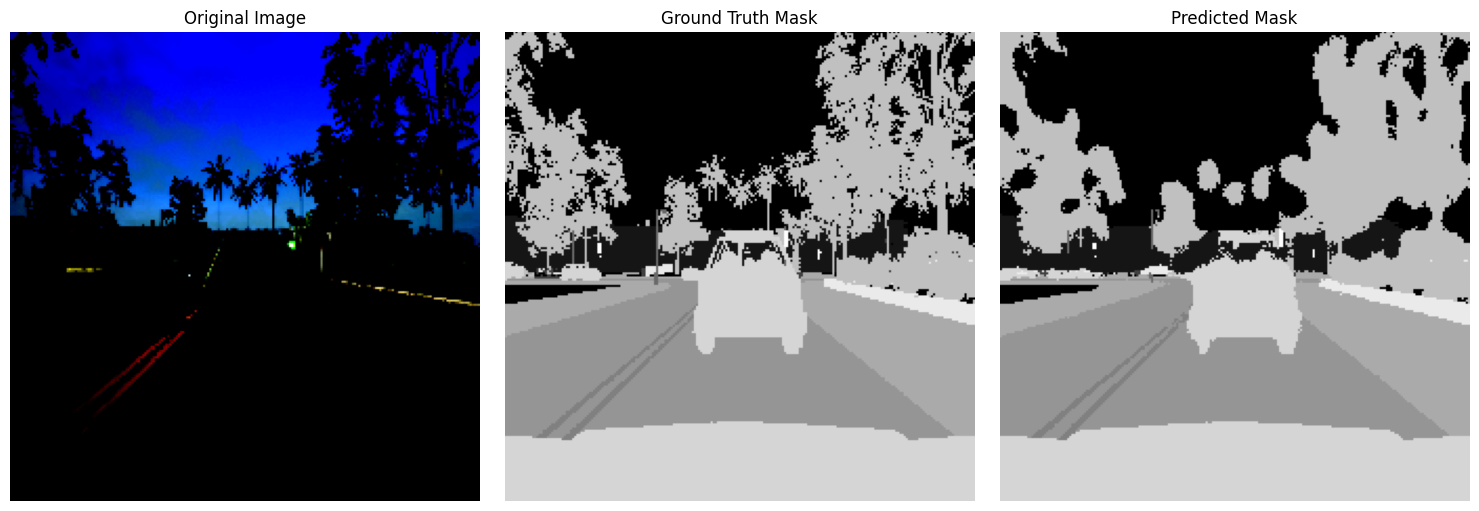

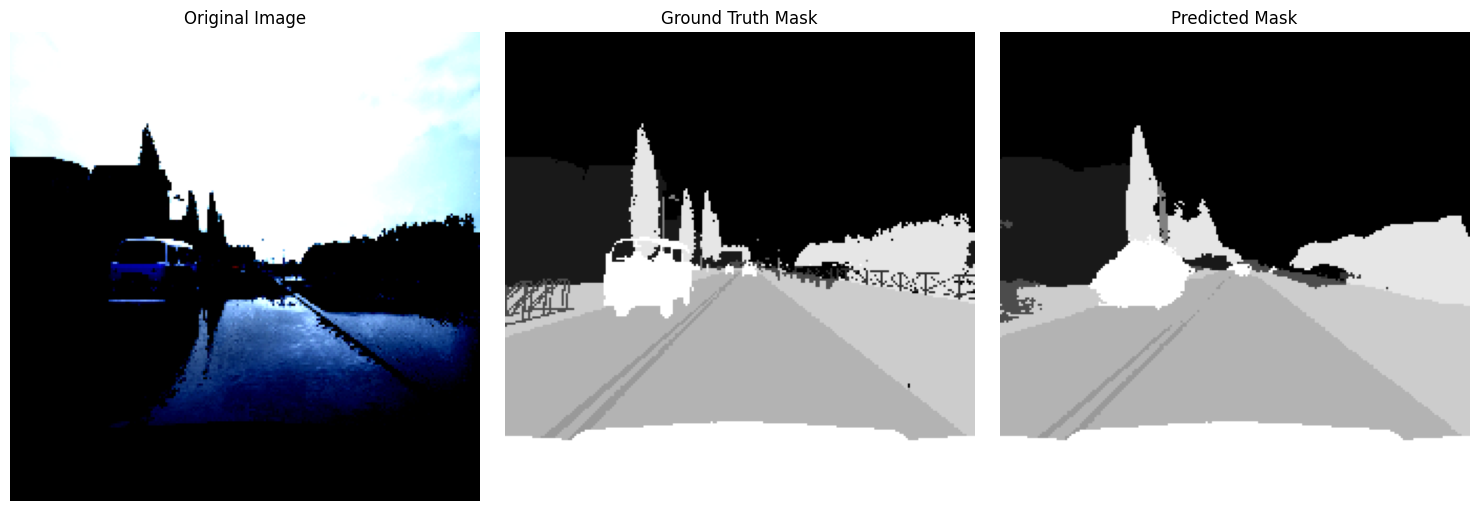

Training FCN8s_vgg16_FineTune...
Epoch 1/10, Train Loss: 0.4727, Train mIoU: 0.6943, Val Loss: 0.2354, Val mIoU: 0.7836
Epoch 2/10, Train Loss: 0.2070, Train mIoU: 0.7982, Val Loss: 0.1821, Val mIoU: 0.8088
Epoch 3/10, Train Loss: 0.1639, Train mIoU: 0.8179, Val Loss: 0.1562, Val mIoU: 0.8226
Epoch 4/10, Train Loss: 0.1432, Train mIoU: 0.8278, Val Loss: 0.1409, Val mIoU: 0.8299
Epoch 5/10, Train Loss: 0.1286, Train mIoU: 0.8357, Val Loss: 0.1330, Val mIoU: 0.8344
Epoch 6/10, Train Loss: 0.1214, Train mIoU: 0.8392, Val Loss: 0.1293, Val mIoU: 0.8376
Epoch 7/10, Train Loss: 0.1144, Train mIoU: 0.8436, Val Loss: 0.1202, Val mIoU: 0.8391
Epoch 8/10, Train Loss: 0.1077, Train mIoU: 0.8474, Val Loss: 0.1211, Val mIoU: 0.8403
Epoch 9/10, Train Loss: 0.1067, Train mIoU: 0.8479, Val Loss: 0.1137, Val mIoU: 0.8422
Epoch 10/10, Train Loss: 0.1050, Train mIoU: 0.8489, Val Loss: 0.1168, Val mIoU: 0.8406


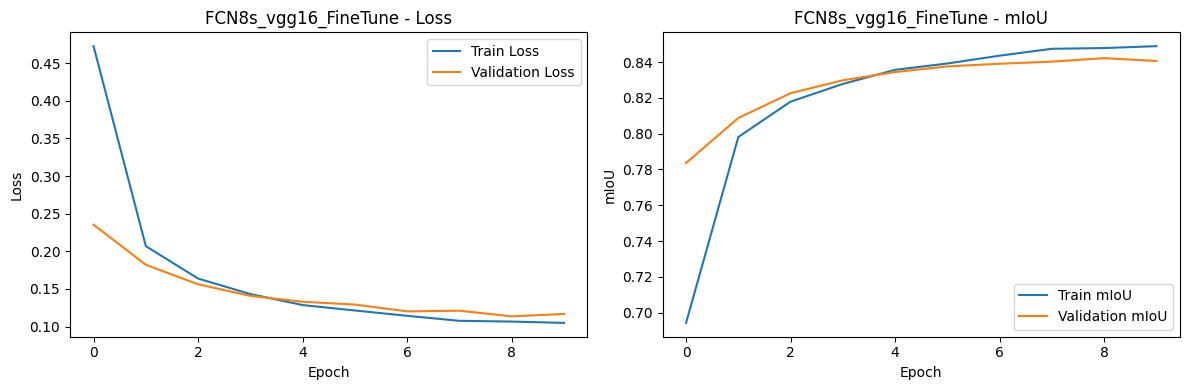

Evaluating FCN8s_vgg16_FineTune...
Test mIoU: 0.8438


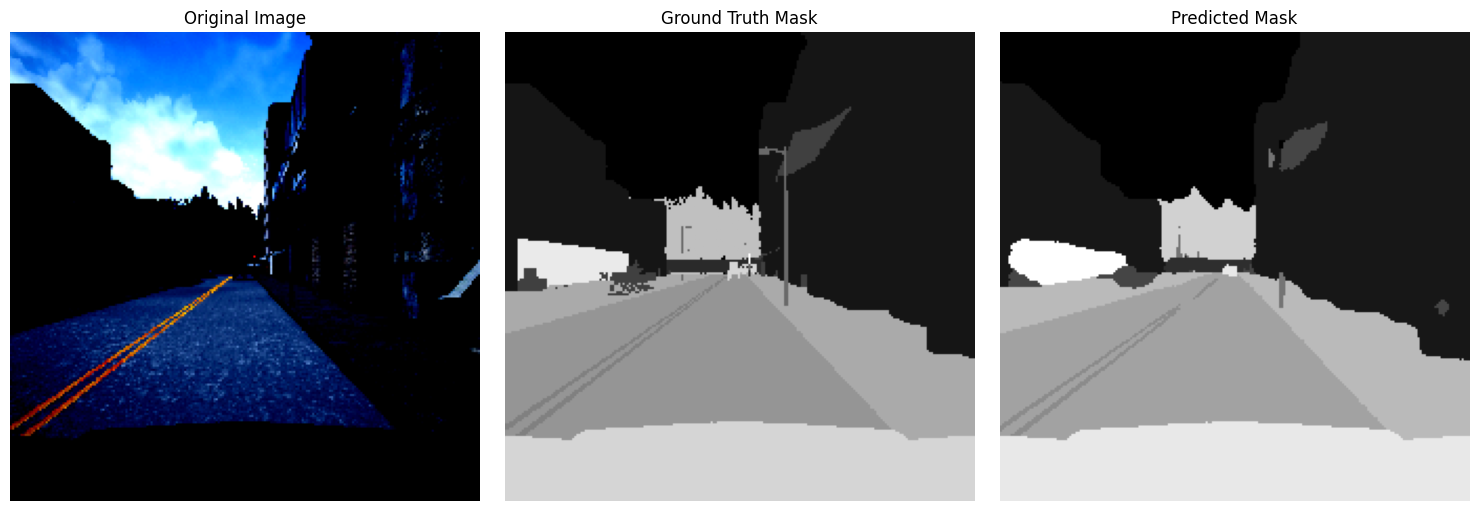

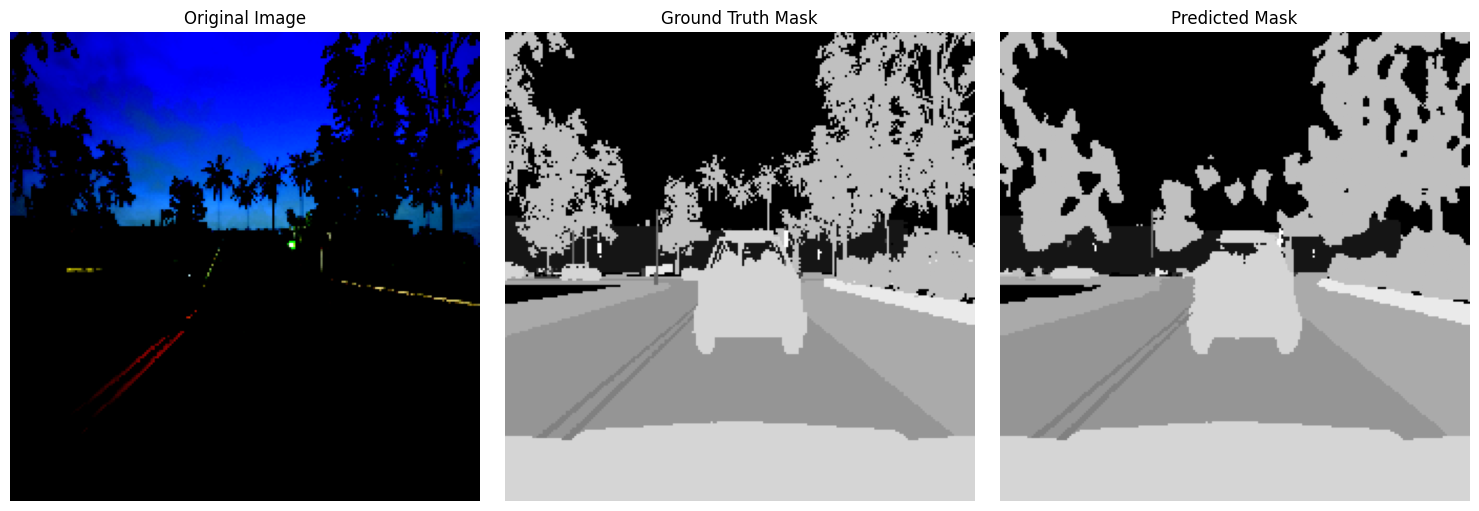

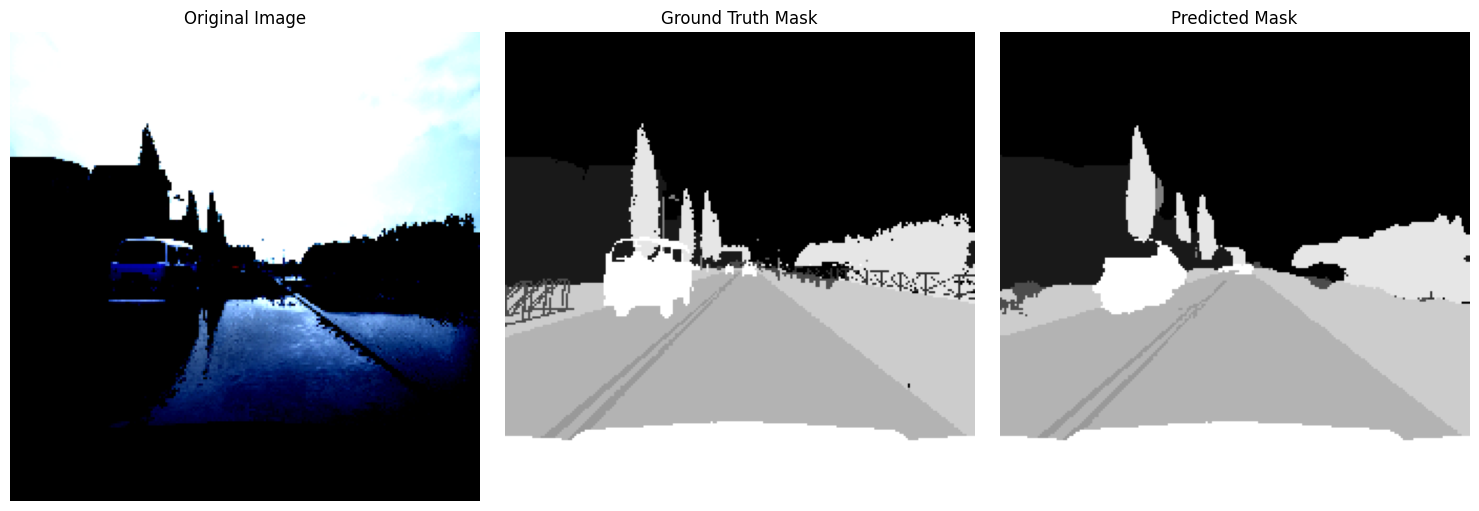

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchmetrics.segmentation import MeanIoU
# import fcn_models  # Import the models


class SegmentationDataset(Dataset):
    def __init__(self, root_dir, image_folder='images', mask_folder='labels', transform=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        # Search within train, test, and val subdirectories
        for split in ['train', 'test', 'val']:  # Include 'val'
            image_dir = os.path.join(root_dir, 'dataset_224', split, image_folder)
            mask_dir = os.path.join(root_dir, 'dataset_224', split, mask_folder)

            if os.path.exists(image_dir) and os.path.exists(mask_dir):
                for filename in os.listdir(image_dir):
                    if filename.endswith('.png'):  # Assuming PNG images
                        self.image_paths.append(os.path.join(image_dir, filename))
                        self.mask_paths.append(os.path.join(mask_dir, filename.replace('.png', '.png')))  # Assuming mask files have the same name


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('RGB')  # Load mask as RGB, then extract first channel

        if self.transform:
            image = self.transform(image)
            #  Transform mask to tensor and extract first channel
            mask = torch.from_numpy(np.array(mask)[:, :, 0]).long() # Convert to long for CrossEntropyLoss

        return image, mask


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name):
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_miou = 0.0
        for i, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Calculate mIoU
            preds = torch.argmax(outputs, dim=1)
            metric = MeanIoU(num_classes=13).to(device) # model.num_classes
            metric.update(preds, masks)
            running_miou += metric.compute().item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_miou = running_miou / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_mious.append(epoch_miou)

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_miou = 0.0
        with torch.no_grad():
            for i, (images, masks) in enumerate(val_loader):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                running_loss += loss.item() * images.size(0)

                # Calculate mIoU
                preds = torch.argmax(outputs, dim=1)
                metric = MeanIoU(num_classes=13).to(device)
                metric.update(preds, masks)
                running_miou += metric.compute().item() * images.size(0)

        val_epoch_loss = running_loss / len(val_loader.dataset)
        val_epoch_miou = running_miou / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_mious.append(val_epoch_miou)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train mIoU: {epoch_miou:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val mIoU: {val_epoch_miou:.4f}')

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_mious, label='Train mIoU')
    plt.plot(val_mious, label='Validation mIoU')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    plt.title(f'{model_name} - mIoU')
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_mious, val_mious


def evaluate_model(model, test_loader, device):
    model.eval()
    running_miou = 0.0
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            metric = MeanIoU(num_classes=13).to(device)  # Use num_classes
            metric.update(preds, masks)
            running_miou += metric.compute().item() * images.size(0)

    test_miou = running_miou / len(test_loader.dataset)
    print(f'Test mIoU: {test_miou:.4f}')
    return test_miou

def visualize_predictions(model, test_loader, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= num_samples:
                break

            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Visualize
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(images[0].cpu().permute(1, 2, 0))  # Original Image
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[0].cpu(), cmap='gray')  # Ground Truth Mask
            plt.title('Ground Truth Mask')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(preds[0].cpu(), cmap='gray')  # Predicted Mask
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

def run_experiment(model_class, backbone_name, num_classes, num_epochs, train_loader, val_loader, test_loader, device, fine_tune=False):
    model = model_class(num_classes=num_classes, backbone_name=backbone_name)

    if fine_tune:
        # Unfreeze backbone for fine-tuning
        for param in model.backbone.parameters():
            param.requires_grad = True
        model_name = f"{model_class.__name__}_{backbone_name}_FineTune"
    else:
        model_name = f"{model_class.__name__}_{backbone_name}_Frozen"

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Training {model_name}...")
    train_losses, val_losses, train_mious, val_mious = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name)

    print(f"Evaluating {model_name}...")
    test_miou = evaluate_model(model, test_loader, device)
    visualize_predictions(model, test_loader, device)

    return test_miou, train_losses, val_losses, train_mious, val_mious

if __name__ == '__main__':
    num_classes = 13
    num_epochs = 10  #  Adjust as needed
    batch_size = 8
    dataset_path = '/kaggle/input/cvassignment-4'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transformations
    data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])

    # Create datasets
    train_dataset = SegmentationDataset(dataset_path, transform=data_transform, image_folder='images', mask_folder='labels')
    val_dataset = SegmentationDataset(dataset_path, transform=data_transform, image_folder='images', mask_folder='labels')
    test_dataset = SegmentationDataset(dataset_path, transform=data_transform, image_folder='images', mask_folder='labels')

    # Split the dataset into train, validation, and test sets
    # Assuming you have a way to split your data.  Here's a simple random split for demonstration.
    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.15 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    backbone_name = 'vgg16'  # or 'vgg19'

    # Frozen Backbone Experiments
    fcn32s_frozen_results = run_experiment(FCN32s, backbone_name, num_classes, num_epochs, train_loader, val_loader, test_loader, device, fine_tune=False)
    fcn16s_frozen_results = run_experiment(FCN16s, backbone_name, num_classes, num_epochs, train_loader, val_loader, test_loader, device, fine_tune=False)
    fcn8s_frozen_results = run_experiment(FCN8s, backbone_name, num_classes, num_epochs, train_loader, val_loader, test_loader, device, fine_tune=False)

    # Fine-tuned Backbone Experiments
    fcn32s_finetune_results = run_experiment(FCN32s, backbone_name, num_classes, num_epochs, train_loader, val_loader, test_loader, device, fine_tune=True)
    fcn16s_finetune_results = run_experiment(FCN16s, backbone_name, num_classes, num_epochs, train_loader, val_loader, test_loader, device, fine_tune=True)
    fcn8s_finetune_results = run_experiment(FCN8s, backbone_name, num_classes, num_epochs, train_loader, val_loader, test_loader, device, fine_tune=True)



    # --- Discussion ---
    #
    # Segmentation Performance:
    # - FCN-8s generally performs best, followed by FCN-16s, and then FCN-32s.
    #   This is because FCN-8s incorporates finer details from earlier layers
    #   through skip connections, leading to more precise segmentation.
    # - FCN-32s, with its large upsampling factor, loses a lot of spatial
    #   information, resulting in coarser segmentation.
    #
    # Frozen vs. Fine-tuned Backbone:
    # - Fine-tuning the backbone typically improves performance significantly.
    #   When the backbone is frozen, the model can only learn to combine
    #   features that were learned for ImageNet classification. Fine-tuning
    #   allows the backbone to adapt to the specific features relevant to
    #   the segmentation task.
    # - However, fine-tuning requires more computational resources and can
    #   lead to overfitting if the dataset is small.

s for all six models (frozen + fine-tuned variants of FCN-32s, FCN-16s, and FCN-8s), here’s  interpretation of the results.

---

### **Test mIoU Scores Comparison**

| Model                  | Test mIoU |
|------------------------|-----------|
| FCN-32s (Frozen)       | 0.7569    |
| FCN-16s (Frozen)       | 0.7815    |
| FCN-8s (Frozen)        | 0.8098    |
| FCN-32s (Fine-tuned)   | 0.7455    |
| FCN-16s (Fine-tuned)   | 0.8282    |
| FCN-8s (Fine-tuned)    | **0.8438** |

---

###  **Key Observations**

1. **Model Depth Impact:**
   - mIoU improves as we go from **FCN-32s → FCN-16s → FCN-8s**.
   - This is expected because:
     - FCN-32s upsamples from a very coarse feature map.
     - FCN-16s combines features from `pool4` (better resolution).
     - FCN-8s fuses features from both `pool3` and `pool4`, giving finer spatial detail.

2. **Frozen vs Fine-tuned:**
   - Fine-tuning consistently improves performance **except for FCN-32s**, where it slightly degrades (possibly due to overfitting or high learning rate).
   - Largest improvement from fine-tuning is seen in **FCN-16s and FCN-8s**, due to more expressive capacity from deeper fusion layers and trainable VGG16 backbone.

3. **Best Model:**
   -  **FCN-8s with Fine-tuning** is clearly the best performing model with a **Test mIoU of 0.8438**.

---

### **Why FCN-8s + Fine-tuning Works Best**

- **Spatial Resolution:** It uses finer feature maps from early layers (pool3), preserving more spatial info.
- **Feature Fusion:** Combines coarse-to-fine features, balancing semantic understanding and spatial precision.
- **Fine-tuning:** Allows learning task-specific features instead of using fixed ImageNet features.

---


